In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

In [2]:
class Args(object):
    def __init__(self):
        self.data_path= 'data'
        self.dataset= 'pwc'
        self.batch_size= 32
        self.model= 'dncnn1d_partialconv'
        self.noise_mode= 'B'
        self.noise_std= 25
        self.min_noise= 0.0
        self.max_noise= 10.0
        self.lr= 0.001
        self.num_epochs= 20
        self.n_data = 5000
        self.valid_interval= 1
        self.save_interval= 1
        self.seed = 0
        self.output_dir= 'experiments'
        self.experiment= None
        self.resume_training= False
        self.restore_file= None
        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 100
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False
        self.in_channels= 1
        self.hidden_size= 64
        self.num_layers= 20
        self.batchnorm= True
        self.bias= False
        self.test_num = 0
args=Args()

In [3]:
# MODEL_PATH = "models/inpainting/dncnn1d_partialconv_10kdata_100epoch_08_09_20.pth"
MODEL_PATH = "models/inpainting/dncnn1d_partialconv_5kdata_20epoch_08_12_20.pth"

train_new_model = True

# Saving model
# torch.save(model.state_dict(), MODEL_PATH)

# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
utils.setup_experiment(args)
utils.init_logging(args)

# Build data loaders, a model and an optimizer
if train_new_model:
    model = models.build_model(args).to(device)
else:
    model = models.build_model(args)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(device)

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 60, 70, 80, 90, 100], gamma=0.5)
logging.info(f"Built a model consisting of {sum(p.numel() for p in model.parameters()):,} parameters")

if args.resume_training:
    state_dict = utils.load_checkpoint(args, model, optimizer, scheduler)
    global_step = state_dict['last_step']
    start_epoch = int(state_dict['last_step']/(403200/state_dict['args'].batch_size))+1
else:
    global_step = -1
    start_epoch = 0

[2020-08-12 17:56:20] COMMAND: /home/michael/python-virtual-environments/bfcnn/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/michael/.local/share/jupyter/runtime/kernel-0274736b-7e07-4f76-8f70-316fc5371649.json
[2020-08-12 17:56:20] Arguments: {'data_path': 'data', 'dataset': 'pwc', 'batch_size': 32, 'model': 'dncnn1d_partialconv', 'noise_mode': 'B', 'noise_std': 25, 'min_noise': 0.0, 'max_noise': 10.0, 'lr': 0.001, 'num_epochs': 20, 'n_data': 5000, 'valid_interval': 1, 'save_interval': 1, 'seed': 0, 'output_dir': 'experiments', 'experiment': 'dncnn1d-partialconv-BF-0.0-10.0-Aug-12-17:56:20', 'resume_training': False, 'restore_file': None, 'no_save': False, 'step_checkpoints': False, 'no_log': False, 'log_interval': 100, 'no_visual': False, 'visual_interval': 100, 'no_progress': False, 'draft': False, 'dry_run': False, 'in_channels': 1, 'hidden_size': 64, 'num_layers': 20, 'batchnorm': True, 'bias': False, 'test_num': 0, 'experiment_dir': 'experiments/dncnn1d_partialconv/d

DnCNNPartialConv(
  (first_layer): PartialConv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (hidden_layer_list): ModuleList(
    (0): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (2): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (3): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (4): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (5): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (6): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (7): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (8): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (9): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,)

In [4]:
# build_dataset is a function in utils/data/__init__.py
train_loader, valid_loader, _ = data.build_dataset(args.dataset,
                                                   args.n_data, 
                                                   batch_size=args.batch_size)

In [5]:
# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in (["train_loss", "train_psnr", "train_ssim"])}
valid_meters = {name: utils.AverageMeter() for name in (["valid_psnr", "valid_ssim"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None

In [6]:
# TRAINING
for epoch in range(start_epoch, args.num_epochs):
    if args.resume_training:
        if epoch %10 == 0:
            optimizer.param_groups[0]["lr"] /= 2
            print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loader, epoch)
    for meter in train_meters.values():
        meter.reset()

    for batch_id, (clean, mask) in enumerate(train_bar):
        # dataloader returns [clean, mask] list
        model.train()
#         print("Epoch: {}\tBatch id: {}".format(epoch,batch_id))
#         print("clean: ",clean[0])
        global_step += 1
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = model(inputs,mask_inputs)
        outputs = (1-mask_inputs)*raw_outputs + mask_inputs*inputs
        
        # TO DO, only run loss on masked part of output
        loss = F.mse_loss(outputs, inputs, reduction="sum") / (inputs.size(0) * 2)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_psnr = utils.psnr(outputs, inputs)
        train_ssim = utils.ssim(outputs, inputs)
        train_meters["train_loss"].update(loss.item())
        train_meters["train_psnr"].update(train_psnr.item())
        train_meters["train_ssim"].update(train_ssim.item())
        train_bar.log(dict(**train_meters, lr=optimizer.param_groups[0]["lr"]), verbose=True)

        if writer is not None and global_step % args.log_interval == 0:
            writer.add_scalar("lr", optimizer.param_groups[0]["lr"], global_step)
            writer.add_scalar("loss/train", loss.item(), global_step)
            writer.add_scalar("psnr/train", train_psnr.item(), global_step)
            writer.add_scalar("ssim/train", train_ssim.item(), global_step)
            gradients = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None], dim=0)
            writer.add_histogram("gradients", gradients, global_step)
            sys.stdout.flush()

    if epoch % args.valid_interval == 0:
        model.eval()
        for meter in valid_meters.values():
            meter.reset()

        valid_bar = utils.ProgressBar(valid_loader)
        
        for sample_id, (clean, mask) in enumerate(valid_bar):
            with torch.no_grad():
                inputs = clean.to(device)
                mask_inputs = mask.to(device)
                # only use the mask part of the outputs
                raw_output = model(inputs,mask_inputs)
                output = (1-mask_inputs)*raw_output + mask_inputs*inputs
                
#                 sample = noisy_clean_sample[1].to(device)
#                 noisy_inputs = noisy_clean_sample[0].to(device);
#                 output = model(noisy_inputs)

                valid_psnr = utils.psnr(inputs, output)
                valid_meters["valid_psnr"].update(valid_psnr.item())
                valid_ssim = utils.ssim(inputs, output)
                valid_meters["valid_ssim"].update(valid_ssim.item())

                if writer is not None and sample_id < 10:
                    image = torch.cat([inputs, torch.mul(inputs, mask_inputs), output], dim=0)
                    image = torchvision.utils.make_grid(image.clamp(0, 1), nrow=3, normalize=False)
                    writer.add_image(f"valid_samples/{sample_id}", image, global_step)

        if writer is not None:
            writer.add_scalar("psnr/valid", valid_meters['valid_psnr'].avg, global_step)
            writer.add_scalar("ssim/valid", valid_meters['valid_ssim'].avg, global_step)
            sys.stdout.flush()

        logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizer.param_groups[0]["lr"])))
        utils.save_checkpoint(args, global_step, model, optimizer, score=valid_meters["valid_psnr"].avg, mode="max")
    scheduler.step()

logging.info(f"Done training! Best PSNR {utils.save_checkpoint.best_score:.3f} obtained after step {utils.save_checkpoint.best_step}.")


[2020-08-12 17:57:08] epoch 00 | train_loss 0.756 | train_psnr 22.571 | train_ssim 0.824 | valid_psnr 22.295 | valid_ssim 0.823 | lr 1.0e-03           
[2020-08-12 17:57:46] epoch 01 | train_loss 0.217 | train_psnr 24.536 | train_ssim 0.845 | valid_psnr 23.712 | valid_ssim 0.839 | lr 1.0e-03           
[2020-08-12 17:58:24] epoch 02 | train_loss 0.178 | train_psnr 25.680 | train_ssim 0.860 | valid_psnr 24.266 | valid_ssim 0.847 | lr 1.0e-03           
[2020-08-12 17:59:02] epoch 03 | train_loss 0.166 | train_psnr 26.098 | train_ssim 0.863 | valid_psnr 26.065 | valid_ssim 0.865 | lr 1.0e-03           
[2020-08-12 17:59:40] epoch 04 | train_loss 0.162 | train_psnr 26.412 | train_ssim 0.867 | valid_psnr 26.067 | valid_ssim 0.862 | lr 1.0e-03           
[2020-08-12 18:00:18] epoch 05 | train_loss 0.161 | train_psnr 26.557 | train_ssim 0.868 | valid_psnr 25.963 | valid_ssim 0.865 | lr 1.0e-03           
[2020-08-12 18:00:56] epoch 06 | train_loss 0.159 | train_psnr 26.540 | train_ssim 0.868

In [7]:
# Best PSNR 28.560
def mask_idx_f(mask):
    mask_start = int(np.argmin(mask[0]))
    mask_length = int((1-mask[0]).sum())
    mask_idx = range(mask_start,mask_start+mask_length)
     # No mask indices
    before = np.arange(mask.shape[2])[:mask_start]
    after = np.arange(mask.shape[2])[mask_start+mask_length:]
    no_mask_idx = np.append(before,after)
    return mask_idx,before, after, mask_length, mask_start

def print_one(loader):
    np.random.seed()
    clean,mask = next(iter(loader))
    outputs = model(clean.to(device),mask.to(device)).cpu()
    
    mask_idx,before_mask,after_mask,mask_length, mask_start = mask_idx_f(mask)

    outputs[0] * (1-mask[0]) + clean[0]*mask[0]    

    out = outputs[0] * (1-mask[0]) + clean[0]*mask[0]
    print("Mask Length: {}\tMask Start: {}".format(mask_length,mask_start))
    
    plt.figure(figsize=[15,8])
    plt.subplot(3,1,1)
    plt.plot(clean[0,0,:],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("True signal")

    plt.subplot(3,1,2)
    masked = clean[0]*mask[0]
    masked_plot = masked[:mask_start,]
    plt.plot(before_mask,masked[0,before_mask],'xb')
    plt.plot(after_mask,masked[0,after_mask],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')

    plt.title("Masked signal")
    plt.subplot(3,1,3)
    plt.plot(out[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')

    plt.title("Denoised signal")

In [15]:
# Test loader is shuffled and allows test_num to force a certain mask shape
_, _, test_loader = data.build_dataset(args.dataset,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   fix_datapoints=False,            
                                                   test_num = 2)

Mask Length: 8	Mask Start: 20


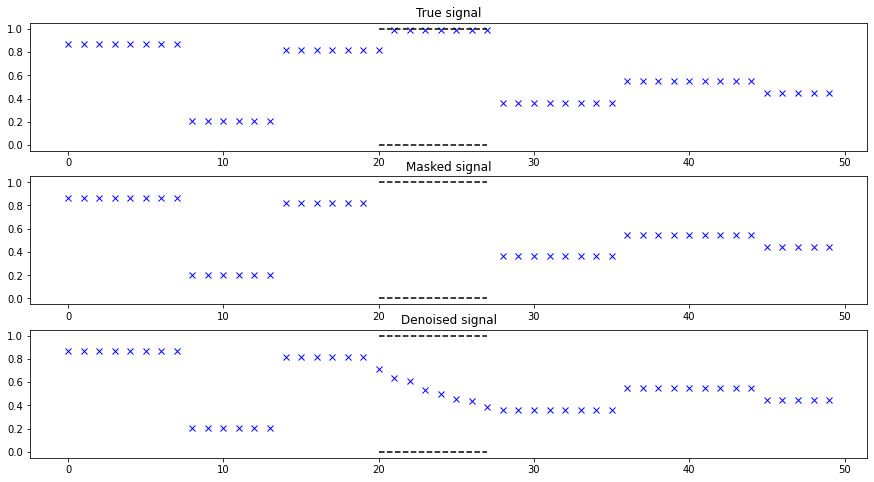

In [16]:
print_one(test_loader)

Mask Length: 10	Mask Start: 20


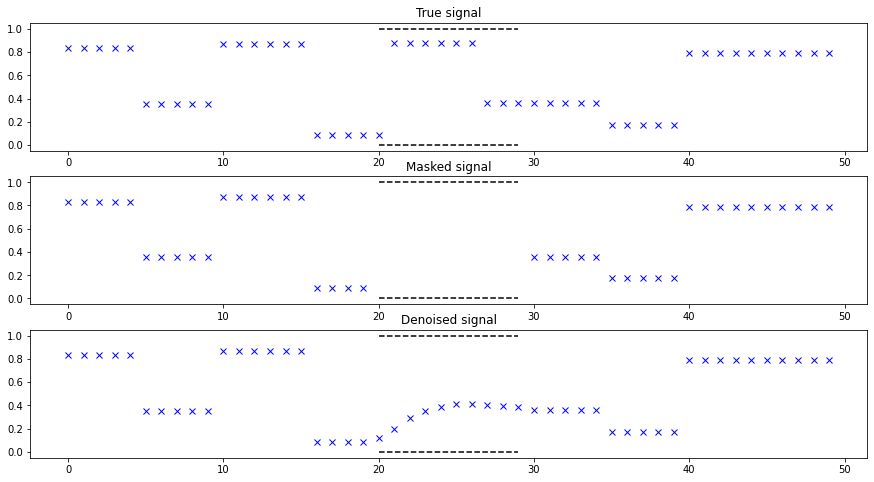

In [17]:
print_one(test_loader)

Mask Length: 7	Mask Start: 20


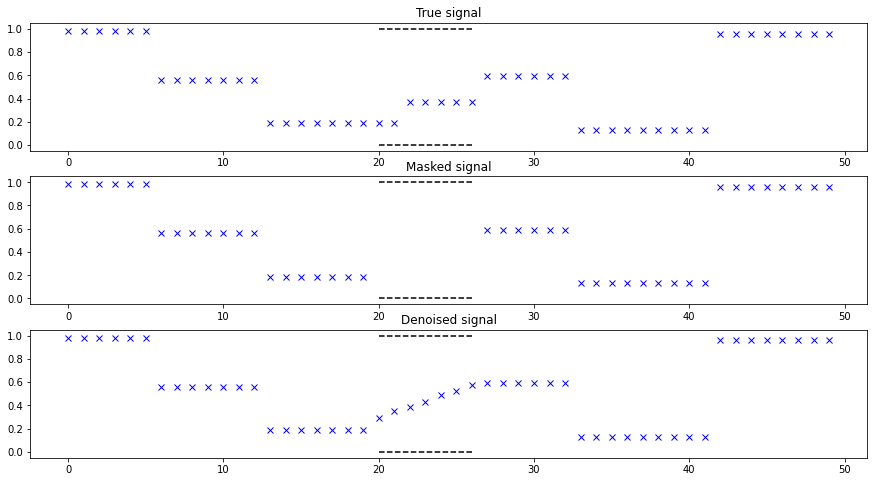

In [18]:
print_one(test_loader)

Mask Length: 10	Mask Start: 20


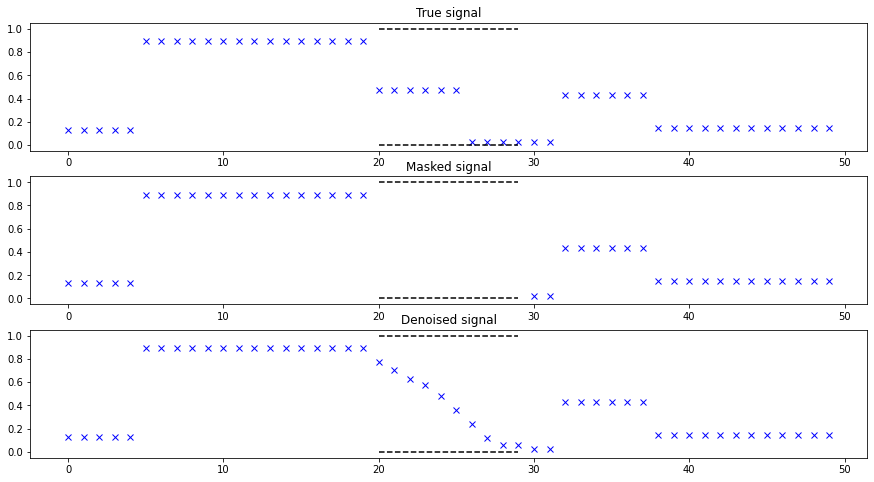

In [19]:
print_one(test_loader)